# Intelligent Data Analysis Project
### Matej Bebej (50%), Marian Kurcina (50%)

## Table of Contents
- Assignment
- Phase 2 - Data preprocessing

# Assignment

Oxygen saturation is a key indicator of the proper functioning of the respiratory and circulatory systems. When its value drops to a critically low level, it may indicate life-threatening conditions such as hypoxemia, respiratory failure, or severe infections. In such cases, immediate intervention is essential. Traditional monitoring is performed using pulse oximeters, which, however, can be affected by noise, motion artifacts, or may have limitations in certain clinical situations.

Modern machine learning–based approaches offer the possibility to estimate and predict critical oxygen saturation values with higher accuracy (critical oxygen saturation estimation). Models can utilize multimodal data, such as heart rate, respiratory rate, blood pressure, or sensor signals. By being trained on diverse datasets, it is possible to identify early warning signs of desaturation, filter out noise, and provide timely alerts even before oxygen saturation drops below a safe threshold.

The goal of this assignment is to become familiar with the issue of oxygen saturation monitoring, understand the contribution of artificial intelligence, and design a solution that could improve critical care and reduce risks associated with undiagnosed hypoxemia.

Each pair of students will work with an assigned dataset starting from Week 2. Your task is to predict the dependent variable “oximetry” (the predicted variable) using machine learning methods. In doing so, you will need to deal with various issues present in the data, such as inconsistent formats, missing values, outliers, and others.

The expected outcomes of the project are:

- the best-performing machine learning model, and

- a data pipeline for building it from the input data.

# Phase 2 – Data Preprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot  as plt
import numpy as np
import dateparser
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer,PolynomialFeatures, OneHotEncoder, FunctionTransformer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression, RFE
from sklearn.svm import SVR
observation = pd.read_csv("dataset/observation.csv", sep='\t')
patient = pd.read_csv("dataset/patient.csv", sep='\t')
station = pd.read_csv("dataset/station.csv", sep='\t')

In this phase, you are expected to carry out data preprocessing for machine learning. The result should be a dataset (CSV or TSV), where each observation is described by one row.
Since scikit-learn only works with numerical data, something must be done with the non-numerical data.

Ensure the preprocessing is reproducible on both the training and test datasets, so that you can repeat the process multiple times as needed (iteratively).

Because preprocessing can change the shape and characteristics of the data, you may need to perform EDA (Exploratory Data Analysis) again as necessary. These techniques will not be graded again, but document any changes in the chosen methods.
You can solve data-related issues iteratively across all phases, as needed.

## 2.1 Implementation of Data Preprocessing

### A - Train–Test Split

Split the data into training and test sets according to your predefined ratio. Continue working only with the training dataset.

In [2]:
before = len(observation)
observation = observation.drop_duplicates()
after = len(observation)
print("Removed duplicates:", before - after)

Removed duplicates: 1


In [3]:
X = observation.drop(columns=["oximetry"])
y = observation["oximetry"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("train shape:", X_train.shape)
print("train shape:", y_train.shape)
print("test shape:", X_test.shape)
print("test shape:", y_test.shape)

train shape: (9684, 22)
train shape: (9684,)
test shape: (2422, 22)
test shape: (2422,)


We split data into train and test parts, with 20% of observation data being test data () and 80% being train data ().

First we preprocess train data by: 
- enforcing schemas on each data frame
- removing latitude and longitude columns from observation since they are not medical data and have no corelation to oxymetry (as we learned in First Phase of the project - EDA)
- removing logical outliers - values which are outside of acceptable range
- removing records which have oxymetry missing 
- removing duplicates

We create a schema - expected format for each dataset and then we check if this format is present in the dataset, if some element is not same as refered in schema we try to cast the content to the correct type, if that is not possible we insert NaN.

In [4]:
station_schema = {
    'location':'string',
    'code':'string',
    'revision':'date',
    'station':'string',
    'latitude':'float',
    'longitude':'float',
}
observation_schema = {
    'SpO₂':'float',
    'HR':'float',
    'PI':'float',
    'RR':'float',
    'EtCO₂':'float',
    'FiO₂':'float',
    'PRV':'float',
    'BP':'float',
    'Skin Temperature':'float',
    'Motion/Activity index':'float',
    'PVI':'float',
    'Hb level':'float',
    'SV':'float',
    'CO':'float',
    'Blood Flow Index':'float',
    'PPG waveform features':'float',
    'Signal Quality Index':'float',
    'Respiratory effort':'float',
    'O₂ extraction ratio':'float',
    'SNR':'float',
    'oximetry':'int',
    'latitude':'float',
    'longitude':'float'
}
patient_schema = {
    'residence':'string',              
    'current_location':'string',    
    'blood_group':'string',          
    'job':'string',                 
    'mail':'string',                
    'user_id':'int',             
    'birthdate':'date',           
    'company':'string',             
    'name':'string',                
    'username':'string',            
    'ssn':'string',                 
    'registration':'date',        
    'station_ID':'int'            
}

In [5]:
class EnforceSchema(BaseEstimator, TransformerMixin):
    def __init__(self, schema=None):
        self.schema = schema

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if self.schema is None:
            return X

        X = X.copy()

        for col, col_type in self.schema.items():
            if col not in X.columns:
                continue
            if col_type == 'int':
                X[col] = pd.to_numeric(X[col], errors='coerce').astype('Int64')

            elif col_type == 'float':
                X[col] = pd.to_numeric(X[col], errors='coerce').astype(float)

            elif col_type == 'numeric':
                X[col] = pd.to_numeric(X[col], errors='coerce')

            elif col_type == 'date':
                X[col] = X[col].apply(
                    lambda x: dateparser.parse(str(x))
                    if pd.notnull(x) else pd.NaT
                )

            elif col_type == 'string':
                X[col] = X[col].astype(str)
                X[col] = X[col].replace('nan', np.nan)

            elif col_type == 'bool':
                X[col] = (
                    X[col]
                    .astype(str)
                    .str.lower()
                    .map({'true': True, 'false': False, '1': True, '0': False})
                )

            elif col_type == 'category':
                X[col] = X[col].astype('category')

    
        return X

In observation dataset we have expected ranges for each attribute, we check if all values are within the range, if not we push the value to the edge of the range.

In [6]:
valid_ranges = {
    'SpO₂': (95, 100),
    'HR': (60, 100),
    'PI': (0.2, 20),
    'RR': (12, 20),
    'EtCO₂': (35, 45),
    'FiO₂': (21, 100),
    'PRV': (20, 200),
    'BP': (60, 120),
    'Skin Temperature': (33, 38),
    'Motion/Activity index': None,
    'PVI': (10, 20),
    'Hb level': (12, 18),
    'SV': (60, 100),
    'CO': (4, 8),
    'Blood Flow Index': None,
    'PPG waveform features': None,
    'Signal Quality Index': (0, 100),
    'Respiratory effort': None,
    'O₂ extraction ratio': (0.2, 3),
    'SNR': (20, 40)
}

In [7]:
class EnforceValueRanges(BaseEstimator, TransformerMixin):
    def __init__(self, ranges=None):
        self.ranges = ranges

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        if self.ranges is None:
            return X

        for col, valid_range in self.ranges.items():
            if col not in X.columns:
                continue
            if valid_range is None:
                continue  

            low, high = valid_range
            X[col] = pd.to_numeric(X[col], errors='coerce')

            mask = ~X[col].between(low, high, inclusive='both')
            X.loc[mask, col] = np.nan

        return X

For table station we have to parse the location column to get continent and city.

In [8]:
def parse_location(X, column='location'):
    X = X.copy()
    if column not in X.columns:
        return X
    
    split_cols = X[column].astype(str).str.split('/', n=1, expand=True)
    X['continent'] = split_cols[0].str.strip()
    X['city'] = split_cols[1].str.strip() if split_cols.shape[1] > 1 else None
    X = X.drop(columns=[column], errors='ignore')
    return X

parse_location_transformer = FunctionTransformer(parse_location, kw_args={'column': 'location'}, validate=False)

Furthermore we create functions for other dataset transformations that we will need.

In [9]:
def drop_columns(X, y=None, columns=None):
    X_transformed = X.drop(columns=columns or [], errors='ignore').copy()
    if y is not None:
        return X_transformed, y
    return X_transformed

dropcolumns_transformer = FunctionTransformer(
    drop_columns, kw_args={'columns': []}, validate=False
)

In [10]:
def drop_na(X, y=None, how='any', subset=None):
    mask = X.dropna(how=how, subset=subset).index
    X_transformed = X.loc[mask].copy()
    if y is not None:
        y_transformed = y.loc[mask].copy()
        return X_transformed, y_transformed
    return X_transformed

dropna_transformer = FunctionTransformer(
    drop_na, kw_args={'how': 'any', 'subset': None}, validate=False
)

Lastly we define first version of pipelines. 
For observation pipeline we first enforce schema and ranges so all the values are of correct type and in valid range. Then we remove coordinates since these are not valid medical information and we don't to use them for our model. Then we remove null values and remove duplicates.
For station pipeline we first enforce schema to have all columns as correct data types, then we drop station name and revision date, because we dont want to use these coulumns and they wouldn't hold any relevant information. Then we parse the location to get continent and city of the station. Lastly we drop null values and remove duplicates. This dataset is now ready to provide us additional information about the obseravtions, if it would be needed we can remove deletion of coordinates columns and add to each observation innformation about continent, country (code) and city.
Lastly for patient dataset we only enforce schema and remove duplicates (we don't remove null values because most of the columns are partially empty), this dataset does not provide any additional information for us as we found out in 1st phase. 

In [11]:
observation_pipeline = Pipeline([
    ("schema", EnforceSchema(schema=observation_schema)),
    ("ranges", EnforceValueRanges(ranges=valid_ranges)),
    ("drop_geo", FunctionTransformer(drop_columns, kw_args={'columns': ['latitude', 'longitude']}, validate=False)),
    ("drop_na", FunctionTransformer(drop_na, kw_args={'how': 'any'}, validate=False)),
])

station_pipeline = Pipeline([
    ("schema", EnforceSchema(schema=station_schema)),
    ("drop_station_and_date", FunctionTransformer(drop_columns, kw_args={'columns': ['station', 'revision']}, validate=False)),
    ("parse_location", FunctionTransformer(parse_location, kw_args={'column': 'location'}, validate=False)),
    ("drop_na", FunctionTransformer(drop_na, kw_args={'how': 'any'}, validate=False)),
])

patient_pipeline = Pipeline([
    ("schema", EnforceSchema(schema=patient_schema)),
])

transformed_observation = observation_pipeline.fit_transform(X_train,y_train)
transformed_station = station_pipeline.fit_transform(pd.read_csv("dataset/station.csv", sep='\t'))
transformed_patient = patient_pipeline.fit_transform(pd.read_csv("dataset/patient.csv", sep='\t'))

transformed_station.head()

C:\Users\mbebe\AppData\Local\Temp\ipykernel_21180\1183780406.py:28: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  lambda x: dateparser.parse(str(x))
C:\Users\mbebe\AppData\Local\Temp\ipykernel_21180\1183780406.py:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[col] = X[col].replace('nan', np.nan)
C:\Users\mbebe\AppData\Local\Temp\ipykernel_21180\1183780406.py:28: DeprecationWarning: Parsing dates involving a day of month without a year sp

,code,latitude,longitude,continent,city
0,ES,37.35813,-6.03731,Europe,Madrid
1,CO,7.83389,-72.47417,America,Bogota
2,IN,26.44931,91.61356,Asia,Kolkata
3,US,37.95143,-91.77127,America,Chicago
4,DE,48.21644,9.02596,Europe,Berlin


### B - Data Transformation

Transform the data into a format suitable for machine learning, i.e. each observation must be described by one row, and each attribute must be numeric.
Iteratively integrate preprocessing steps from Phase 1 as part of a unified process.

For observation dataset there are no string or category features, therefore we will show encoding of categorical features on station dataset. In pipeline we will still call encoding but it will have no effect. Furtermore we will only use station and observation datasets since we have relevant information there only.

In [12]:
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

observation_pipeline = Pipeline([
    ("schema", EnforceSchema(schema=observation_schema)),
    ("ranges", EnforceValueRanges(ranges=valid_ranges)),
    ("drop_geo", FunctionTransformer(drop_columns, kw_args={'columns': ['latitude', 'longitude']}, validate=False)),
    ("drop_na", FunctionTransformer(drop_na, kw_args={'how': 'any'}, validate=False)),
    ("encode", ColumnTransformer([
        ('cat', cat_pipeline, [])
    ], remainder='passthrough').set_output(transform="pandas")),
])

station_pipeline = Pipeline([
    ("schema", EnforceSchema(schema=station_schema)),
    ("drop_station_and_date", FunctionTransformer(drop_columns, kw_args={'columns': ['station', 'revision']}, validate=False)),
    ("parse_location", FunctionTransformer(parse_location, kw_args={'column': 'location'}, validate=False)),
    ("drop_na", FunctionTransformer(drop_na, kw_args={'how': 'any'}, validate=False)),
    ("encode", ColumnTransformer([
        ('cat', cat_pipeline, ['continent', 'city', 'code'])
    ], remainder='passthrough').set_output(transform="pandas")),
])





transformed_observation = observation_pipeline.fit_transform(X_train,y_train)
transformed_station = station_pipeline.fit_transform(pd.read_csv("dataset/station.csv", sep='\t'))

transformed_station.head()

C:\Users\mbebe\AppData\Local\Temp\ipykernel_21180\1183780406.py:28: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  lambda x: dateparser.parse(str(x))


,cat__continent_Africa,cat__continent_America,cat__continent_Asia,cat__continent_Atlantic,cat__continent_Australia,cat__continent_Europe,cat__continent_Indian,cat__continent_Pacific,cat__city_Abidjan,cat__city_Accra,...,cat__code_UA,cat__code_US,cat__code_UY,cat__code_UZ,cat__code_VE,cat__code_VU,cat__code_YE,cat__code_ZA,remainder__latitude,remainder__longitude
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.35813,-6.03731
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.83389,-72.47417
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.44931,91.61356
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,37.95143,-91.77127
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.21644,9.02596


For encoding we have put Column transformer in our pipelines, in here the transformations and scalers will be defined too. We have added remainder='passthrough' option in the column transformer to keep the columns that are not transformed in any way. After the transforms we had an issue with the step returning the numpy array which did not contain columns names, to fix this we have used .set_output(transform="pandas") option for the column transformer. This will force the step to output pandas dataframe to the next step.
For categorical columns we first replace null values with most frequent value and then we encode them. 

### C - Feature Scaling and Transformation

Transform the dataset attributes for machine learning using at least the following techniques:

- Scaling (2 techniques)
- Transformers (2 techniques)

 #### Scaling

##### StandardScaler
For each numeric column, it computes formula: $z = (x - mean)/ std$, with mean = 0 and std = 1
StandardScaler makes each column "comparable" in scale. Prevents some features being too influential simply because of their scale.

In [13]:
def get_numeric_columns(df):
    return df.select_dtypes(include=['int', 'float']).columns.tolist()

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

numeric_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    #("scaler", MinMaxScaler(feature_range=(-1, 1)))
])

observation_pipeline = Pipeline([
    ("schema", EnforceSchema(schema=observation_schema)),
    ("ranges", EnforceValueRanges(ranges=valid_ranges)),
    ("drop_geo", FunctionTransformer(drop_columns, kw_args={'columns': ['latitude', 'longitude']}, validate=False)),
    ("drop_na", FunctionTransformer(drop_na, kw_args={'how': 'any'}, validate=False)),
    ("encode", ColumnTransformer([
        ('cat', cat_pipeline, []),
        ('num', numeric_pipeline, get_numeric_columns)
    ], remainder='passthrough').set_output(transform="pandas")),
])

station_pipeline = Pipeline([
    ("schema", EnforceSchema(schema=station_schema)),
    ("drop_station_and_date", FunctionTransformer(drop_columns, kw_args={'columns': ['station', 'revision']}, validate=False)),
    ("parse_location", FunctionTransformer(parse_location, kw_args={'column': 'location'}, validate=False)),
    ("drop_na", FunctionTransformer(drop_na, kw_args={'how': 'any'}, validate=False)),
    ("encode", ColumnTransformer([
        ('cat', cat_pipeline, ['continent', 'city', 'code']),
        ('num', numeric_pipeline, get_numeric_columns)
    ], remainder='passthrough').set_output(transform="pandas")),
])




transformed_observation = observation_pipeline.fit_transform(X_train,y_train)
transformed_station = station_pipeline.fit_transform(pd.read_csv("dataset/station.csv", sep='\t'))

transformed_observation.head()

C:\Users\mbebe\AppData\Local\Temp\ipykernel_21180\1183780406.py:28: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  lambda x: dateparser.parse(str(x))


,num__SpO₂,num__HR,num__PI,num__RR,num__EtCO₂,num__FiO₂,num__PRV,num__BP,num__Skin Temperature,num__Motion/Activity index,num__PVI,num__Hb level,num__SV,num__CO,num__Blood Flow Index,num__PPG waveform features,num__Signal Quality Index,num__Respiratory effort,num__O₂ extraction ratio,num__SNR
108,1.953852,0.032699,1.222765,0.732980,0.382418,-0.229489,0.320303,1.900541,0.891793,1.388571,0.314696,-0.872217,0.530179,-0.268116,-0.754105,-0.465557,-0.706253,1.279517,-0.539533,1.003425
12092,-0.991307,0.266432,0.549494,-1.610561,-0.139343,1.056711,0.443323,0.585270,-0.307794,-0.968697,-1.202764,-0.297119,0.206366,-0.165222,0.820335,0.229577,-0.751795,0.979515,0.789101,-1.425010
9658,-2.102740,0.593181,0.226362,-3.443886,-0.014848,1.979283,-0.563047,-0.775902,-0.102475,2.708076,0.082070,0.374047,-0.398170,0.088075,-0.844645,-0.020597,1.879169,1.608523,0.392014,-1.071256
2929,-0.522682,-0.408683,-0.316020,-0.381465,0.273402,0.226677,-0.691574,-0.831748,-2.301060,-1.472041,-1.174046,1.731231,0.810748,-0.429002,-1.756642,-0.921236,0.397168,-0.562005,1.130631,0.916572
10405,0.634981,0.591865,0.352991,0.862953,1.823320,-0.107193,0.331392,-1.149611,-1.598345,-0.775176,1.254505,-2.122586,1.276494,0.048805,0.019867,0.402615,0.990483,0.075276,1.134043,1.293153


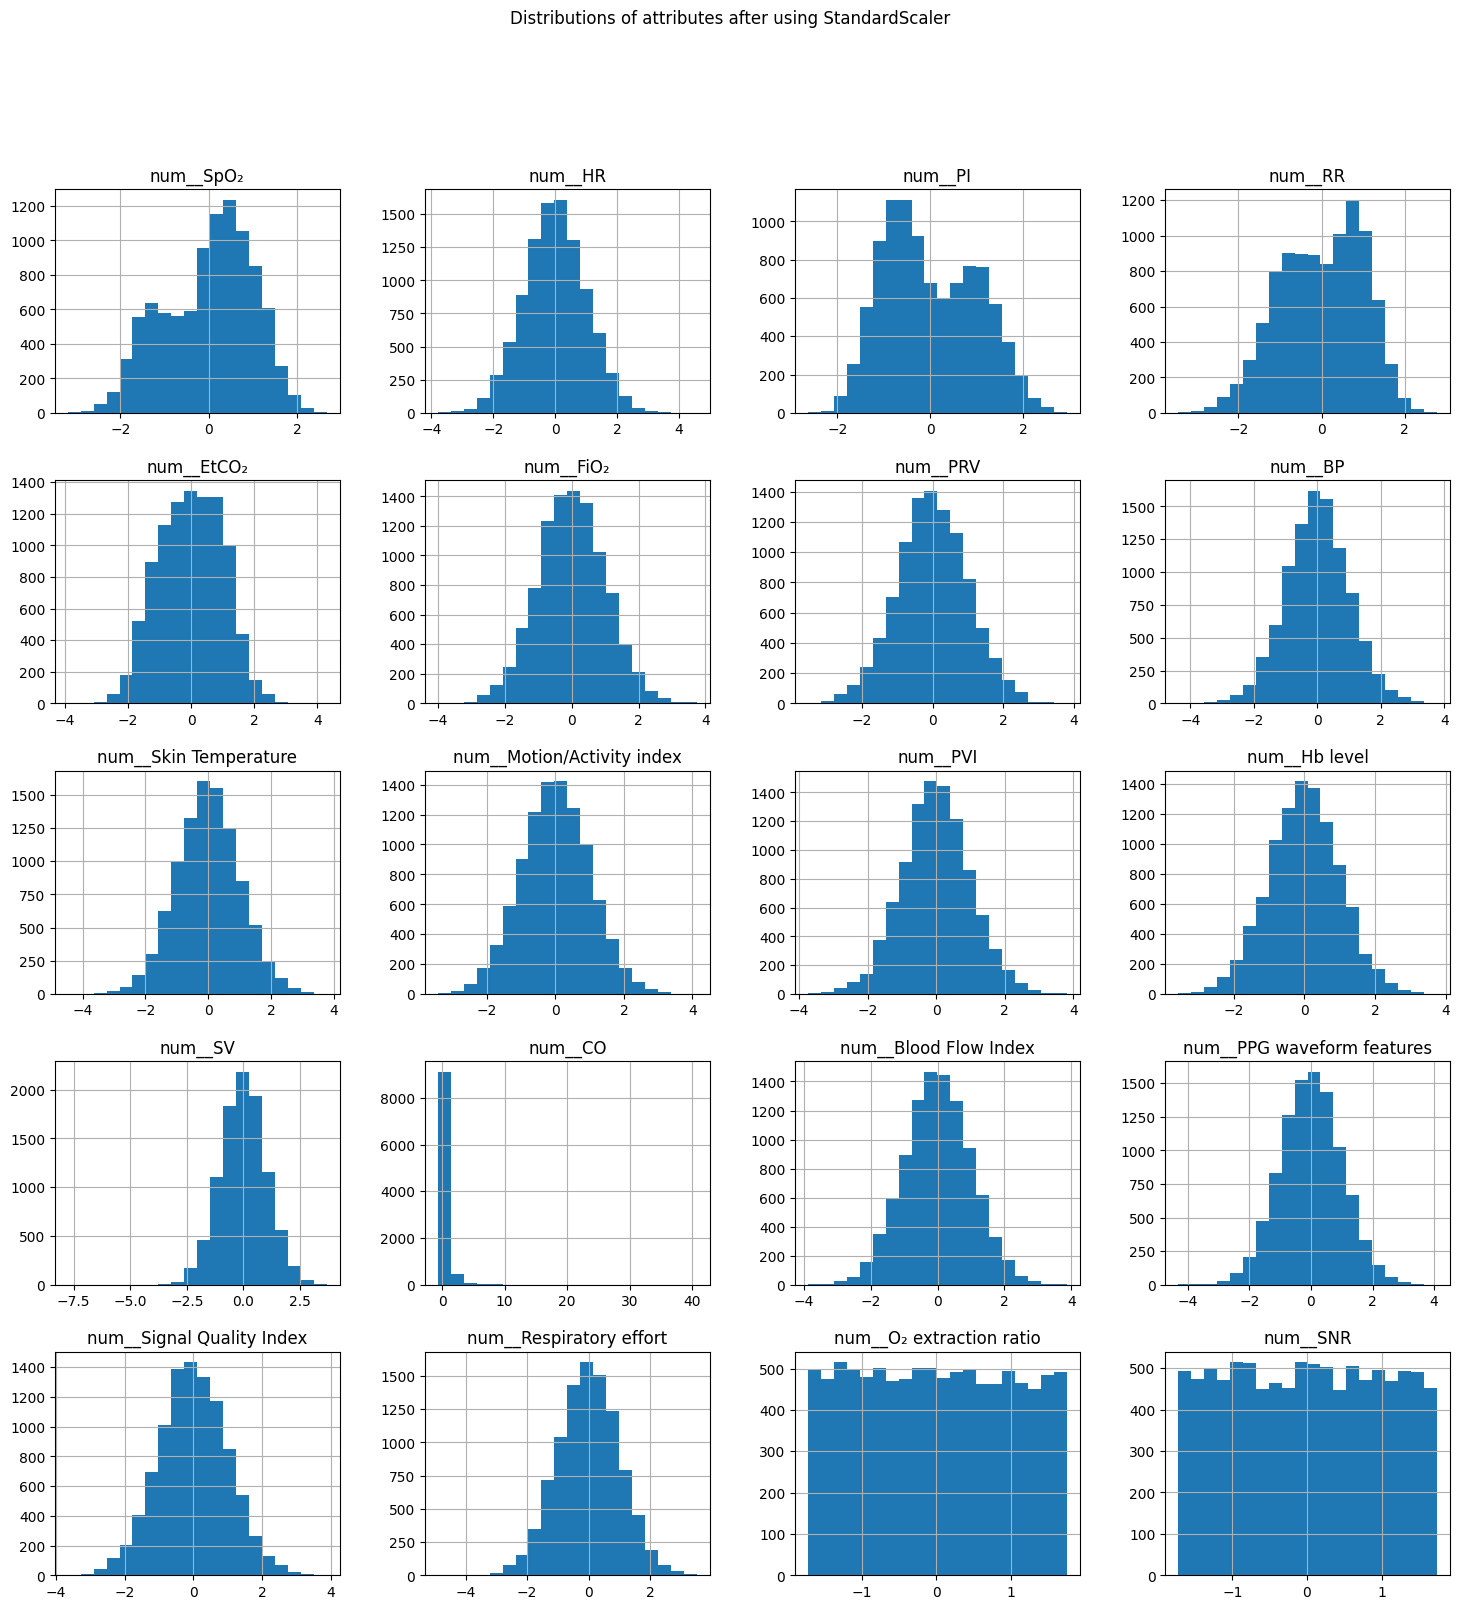

In [14]:
transformed_observation.hist(figsize=(18, 18), bins=20)
plt.suptitle("Distributions of attributes after using StandardScaler")
plt.show()

##### MinMax Scaler
Maps the minimum of each feature to −1 and the maximum to 1. It uses following formula: $z = -1 + 2 * ((x - x(min) / (x(max) - x(min))$
Preserves the original shape of the distribution, only makes the values more tightly bounded.
Good when we need values from smaller ranges (here from -1 to 1).

In [15]:
def get_numeric_columns(df):
    return df.select_dtypes(include=['int', 'float']).columns.tolist()

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

numeric_pipeline = Pipeline([
    #("scaler", StandardScaler()),
    ("scaler", MinMaxScaler(feature_range=(-1, 1)))
])

observation_pipeline = Pipeline([
    ("schema", EnforceSchema(schema=observation_schema)),
    ("ranges", EnforceValueRanges(ranges=valid_ranges)),
    ("drop_geo", FunctionTransformer(drop_columns, kw_args={'columns': ['latitude', 'longitude']}, validate=False)),
    ("drop_na", FunctionTransformer(drop_na, kw_args={'how': 'any'}, validate=False)),
    ("encode", ColumnTransformer([
        ('cat', cat_pipeline, []),
        ('num', numeric_pipeline, get_numeric_columns)
    ], remainder='passthrough').set_output(transform="pandas")),
])

station_pipeline = Pipeline([
    ("schema", EnforceSchema(schema=station_schema)),
    ("drop_station_and_date", FunctionTransformer(drop_columns, kw_args={'columns': ['station', 'revision']}, validate=False)),
    ("parse_location", FunctionTransformer(parse_location, kw_args={'column': 'location'}, validate=False)),
    ("drop_na", FunctionTransformer(drop_na, kw_args={'how': 'any'}, validate=False)),
    ("encode", ColumnTransformer([
        ('cat', cat_pipeline, ['continent', 'city', 'code']),
        ('num', numeric_pipeline, get_numeric_columns)
    ], remainder='passthrough').set_output(transform="pandas")),
])




transformed_observation = observation_pipeline.fit_transform(X_train,y_train)
transformed_station = station_pipeline.fit_transform(pd.read_csv("dataset/station.csv", sep='\t'))

transformed_observation.head()

C:\Users\mbebe\AppData\Local\Temp\ipykernel_21180\1183780406.py:28: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  lambda x: dateparser.parse(str(x))


,num__SpO₂,num__HR,num__PI,num__RR,num__EtCO₂,num__FiO₂,num__PRV,num__BP,num__Skin Temperature,num__Motion/Activity index,num__PVI,num__Hb level,num__SV,num__CO,num__Blood Flow Index,num__PPG waveform features,num__Signal Quality Index,num__Respiratory effort,num__O₂ extraction ratio,num__SNR
108,0.756534,-0.086035,0.385460,0.344547,0.046418,-0.025558,0.050369,0.542354,0.302071,0.275965,0.073675,-0.263522,0.448987,-0.978535,-0.192627,-0.083837,-0.217594,0.468981,-0.319556,0.574116
12092,-0.248824,-0.030191,0.143535,-0.409846,-0.080694,0.306877,0.083884,0.219843,0.010913,-0.347967,-0.328556,-0.106338,0.392417,-0.973574,0.213642,0.081514,-0.229690,0.397657,0.448137,-0.825119
9658,-0.628222,0.047877,0.027425,-1.000000,-0.050365,0.545327,-0.190286,-0.113924,0.060747,0.625218,0.012013,0.077104,0.286804,-0.961361,-0.215990,0.022005,0.469048,0.547200,0.218698,-0.621290
2929,-0.088854,-0.191492,-0.167469,-0.014196,0.019859,0.092344,-0.225301,-0.127617,-0.472883,-0.481194,-0.320944,0.448046,0.498002,-0.986293,-0.451321,-0.192228,0.075455,0.031171,0.645475,0.524072
10405,0.306325,0.047562,0.072926,0.386386,0.397450,0.006051,0.053390,-0.205559,-0.302323,-0.296745,0.322789,-0.605270,0.579367,-0.963255,0.007089,0.122674,0.233029,0.182680,0.647446,0.741054


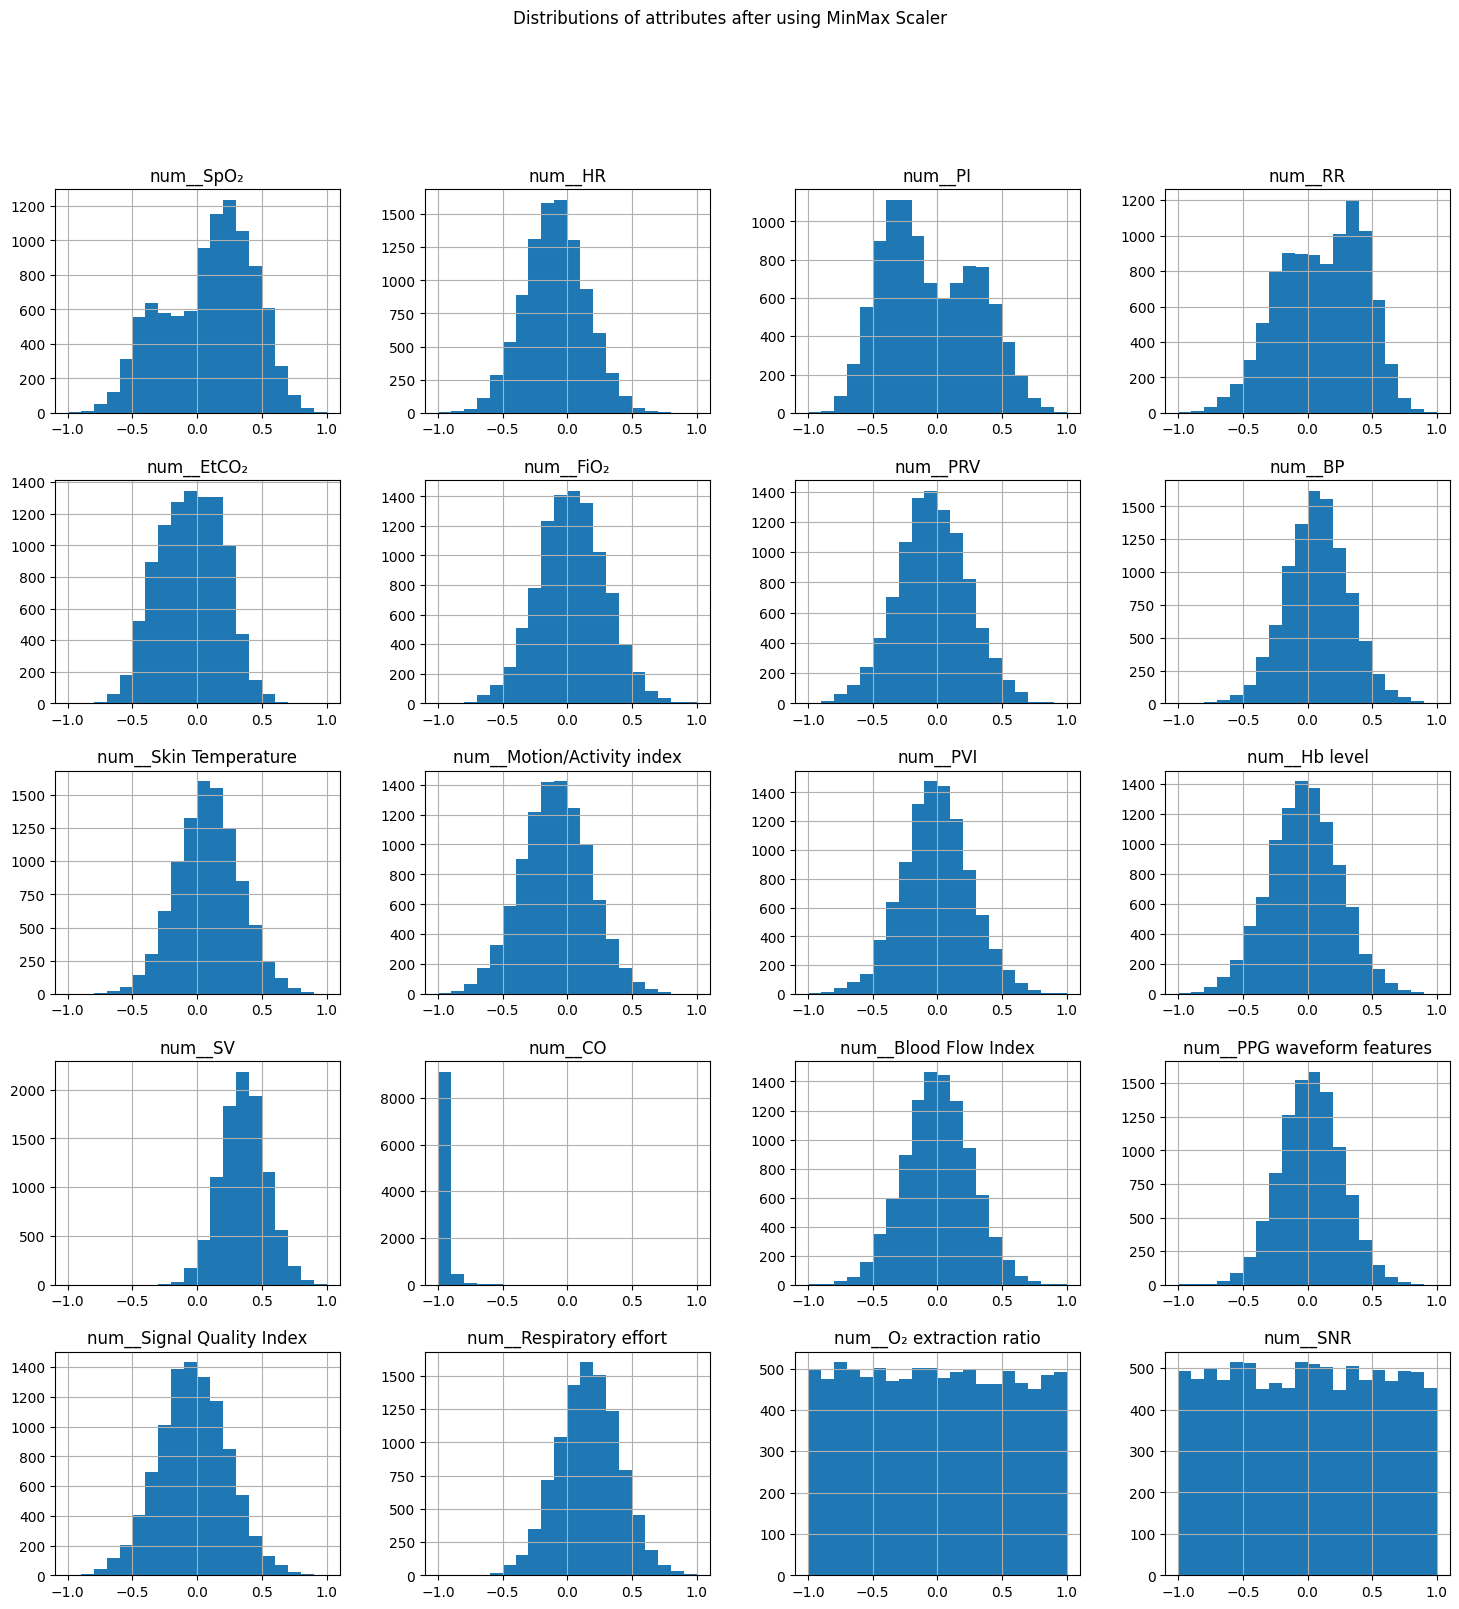

In [16]:
transformed_observation.hist(figsize=(18, 18), bins=20)
plt.suptitle("Distributions of attributes after using MinMax Scaler")
plt.show()

We have put both scalers into our pipeline, but one will be commented out. In need we can use any of the scalers easily.

#### Transformers

##### PowerTransformer (Yeo-Johnson method)

Makes given data from skewed and non-normal into more Gaussian like shape.
There is a big chance of model behaving better when the inputs we feed him are closer to normal

In [17]:
def get_numeric_columns(df):
    return df.select_dtypes(include=['int', 'float']).columns.tolist()

numeric_pipeline = Pipeline([
    ("power", PowerTransformer(method="yeo-johnson")),
    #("poly", PolynomialFeatures(degree=2, include_bias=False)),
    #("scaler", StandardScaler()),
    #("scaler", MinMaxScaler(feature_range=(-1, 1)))
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

observation_pipeline = Pipeline([
    ("schema", EnforceSchema(schema=observation_schema)),
    ("ranges", EnforceValueRanges(ranges=valid_ranges)),
    ("drop_geo", FunctionTransformer(drop_columns, kw_args={'columns': ['latitude', 'longitude']}, validate=False)),
    ("drop_na", FunctionTransformer(drop_na, kw_args={'how': 'any'}, validate=False)),
    ("encode", ColumnTransformer([
        ('cat', cat_pipeline, []),
        ('num', numeric_pipeline, get_numeric_columns)
    ], remainder='passthrough').set_output(transform="pandas")),
])

station_pipeline = Pipeline([
    ("schema", EnforceSchema(schema=station_schema)),
    ("drop_station_and_date", FunctionTransformer(drop_columns, kw_args={'columns': ['station', 'revision']}, validate=False)),
    ("parse_location", FunctionTransformer(parse_location, kw_args={'column': 'location'}, validate=False)),
    ("drop_na", FunctionTransformer(drop_na, kw_args={'how': 'any'}, validate=False)),
    ("encode", ColumnTransformer([
        ('cat', cat_pipeline, ['continent', 'city', 'code']),
        ('num', numeric_pipeline, get_numeric_columns)
    ], remainder='passthrough').set_output(transform="pandas")),
])



transformed_observation = observation_pipeline.fit_transform(X_train,y_train)
transformed_station = station_pipeline.fit_transform(pd.read_csv("dataset/station.csv", sep='\t'))

transformed_observation.head()

C:\Users\mbebe\AppData\Local\Temp\ipykernel_21180\1183780406.py:28: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  lambda x: dateparser.parse(str(x))


,num__SpO₂,num__HR,num__PI,num__RR,num__EtCO₂,num__FiO₂,num__PRV,num__BP,num__Skin Temperature,num__Motion/Activity index,num__PVI,num__Hb level,num__SV,num__CO,num__Blood Flow Index,num__PPG waveform features,num__Signal Quality Index,num__Respiratory effort,num__O₂ extraction ratio,num__SNR
108,2.241529,0.035210,1.186962,0.715950,0.376513,-0.229246,0.321797,1.904921,0.892083,1.385230,0.316855,-0.871952,0.524744,-2.081668e-17,-0.755669,-0.466986,-0.704109,1.284423,-0.532905,1.001671
12092,-1.009404,0.268736,0.608312,-1.543483,-0.146314,1.056657,0.444607,0.584205,-0.306466,-0.968297,-1.203758,-0.296211,0.198872,-6.938894e-18,0.819897,0.228158,-0.749841,0.980227,0.792622,-1.450753
9658,-1.890576,0.594747,0.309697,-2.918234,-0.021913,1.978583,-0.561582,-0.776612,-0.101027,2.687207,0.084497,0.374874,-0.405067,2.081668e-17,-0.845873,-0.022195,1.871305,1.619050,0.399880,-1.073147
2929,-0.588099,-0.406534,-0.229970,-0.431378,0.266957,0.226903,-0.690361,-0.832310,-2.307414,-1.476076,-1.174869,1.729279,0.808427,-3.469447e-17,-1.751408,-0.921782,0.399576,-0.567079,1.128137,0.918762
10405,0.597934,0.593434,0.428541,0.858602,1.840109,-0.106945,0.332869,-1.149125,-1.600628,-0.773598,1.253010,-2.126095,1.282045,1.387779e-17,0.017320,0.401428,0.990062,0.069165,1.131478,1.276149


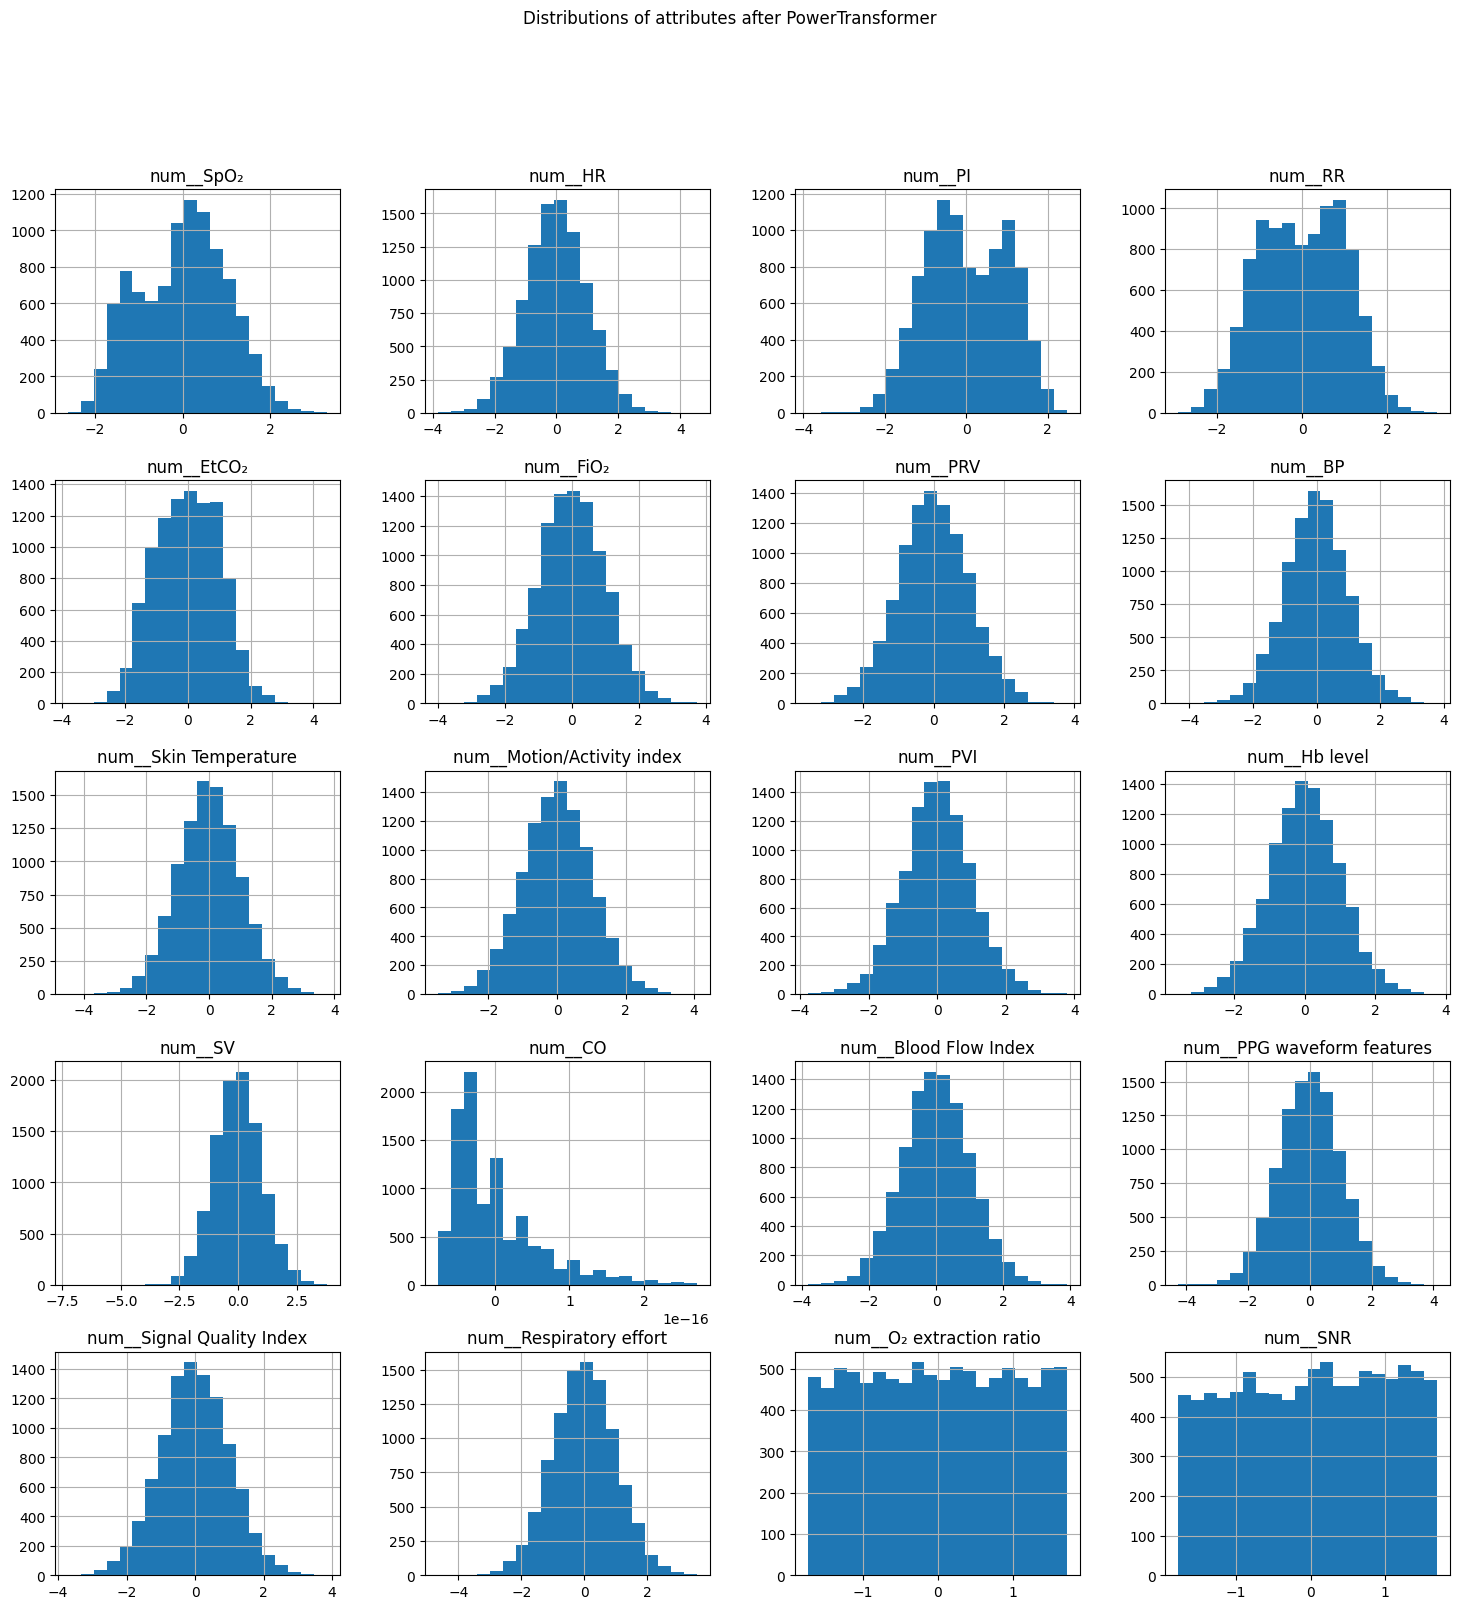

In [18]:
transformed_observation.hist(figsize=(18, 18), bins=20)
plt.suptitle("Distributions of attributes after PowerTransformer")
plt.show()

##### Polynomial features

We create new features which are results of us multiplying existing ones and by that expands the feature space.
We are hoping that this will result in boosting accuracy of our model.

In [19]:
def get_numeric_columns(df):
    return df.select_dtypes(include=['int', 'float']).columns.tolist()

numeric_pipeline = Pipeline([
    #("power", PowerTransformer(method="yeo-johnson")),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    #("scaler", StandardScaler()),
    #("scaler", MinMaxScaler(feature_range=(-1, 1)))
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

observation_pipeline = Pipeline([
    ("schema", EnforceSchema(schema=observation_schema)),
    ("ranges", EnforceValueRanges(ranges=valid_ranges)),
    ("drop_geo", FunctionTransformer(drop_columns, kw_args={'columns': ['latitude', 'longitude']}, validate=False)),
    ("drop_na", FunctionTransformer(drop_na, kw_args={'how': 'any'}, validate=False)), 
    ("encode", ColumnTransformer([
        ('cat', cat_pipeline, []),
        ('num', numeric_pipeline, get_numeric_columns)
    ], remainder='passthrough').set_output(transform="pandas")),
])

station_pipeline = Pipeline([
    ("schema", EnforceSchema(schema=station_schema)),
    ("drop_station_and_date", FunctionTransformer(drop_columns, kw_args={'columns': ['station', 'revision']}, validate=False)),
    ("parse_location", FunctionTransformer(parse_location, kw_args={'column': 'location'}, validate=False)),
    ("drop_na", FunctionTransformer(drop_na, kw_args={'how': 'any'}, validate=False)),
    ("encode", ColumnTransformer([
        ('cat', cat_pipeline, ['continent', 'city', 'code']),
        ('num', numeric_pipeline, get_numeric_columns)
    ], remainder='passthrough').set_output(transform="pandas")),
])


transformed_observation = observation_pipeline.fit_transform(X_train,y_train)
transformed_station = station_pipeline.fit_transform(pd.read_csv("dataset/station.csv", sep='\t'))

transformed_observation.head()

C:\Users\mbebe\AppData\Local\Temp\ipykernel_21180\1183780406.py:28: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  lambda x: dateparser.parse(str(x))


,num__SpO₂,num__HR,num__PI,num__RR,num__EtCO₂,num__FiO₂,num__PRV,num__BP,num__Skin Temperature,num__Motion/Activity index,...,num__Signal Quality Index^2,num__Signal Quality Index Respiratory effort,num__Signal Quality Index O₂ extraction ratio,num__Signal Quality Index SNR,num__Respiratory effort^2,num__Respiratory effort O₂ extraction ratio,num__Respiratory effort SNR,num__O₂ extraction ratio^2,num__O₂ extraction ratio SNR,num__SNR^2
108,99.391335,78.279290,13.490467,17.378190,40.232088,59.490472,114.533205,113.135316,36.255177,11.426540,...,1716.152604,2897.324886,9.694715,1480.630172,4891.459812,16.367273,2499.699988,0.054766,8.364225,1277.430516
12092,96.877940,79.396174,11.169722,14.360614,39.596530,72.621643,117.549557,108.297643,35.527282,9.031558,...,1668.283361,2717.932985,11.126356,888.322075,4428.000591,18.126830,1447.236078,0.074205,5.924525,473.010837
9658,95.929445,80.957537,10.055898,12.000000,39.748177,82.040425,92.874269,103.291147,35.651867,12.767157,...,5544.002349,5484.805865,19.428704,1771.141123,5426.241455,19.221253,1752.229636,0.068087,6.206884,565.826037
2929,97.277864,76.170160,8.186322,15.943216,40.099295,64.147602,89.722888,103.085743,34.317794,8.520161,...,3082.901143,2725.922255,15.672933,1956.701690,2410.279084,13.858114,1730.129004,0.079678,9.947531,1241.908620
10405,98.265812,80.951248,10.492384,17.545545,41.987252,60.739024,114.805099,101.916615,34.744192,9.228175,...,3982.129945,3553.269559,17.818856,2360.759056,3170.595820,15.899832,2106.514203,0.079734,10.563700,1399.548331


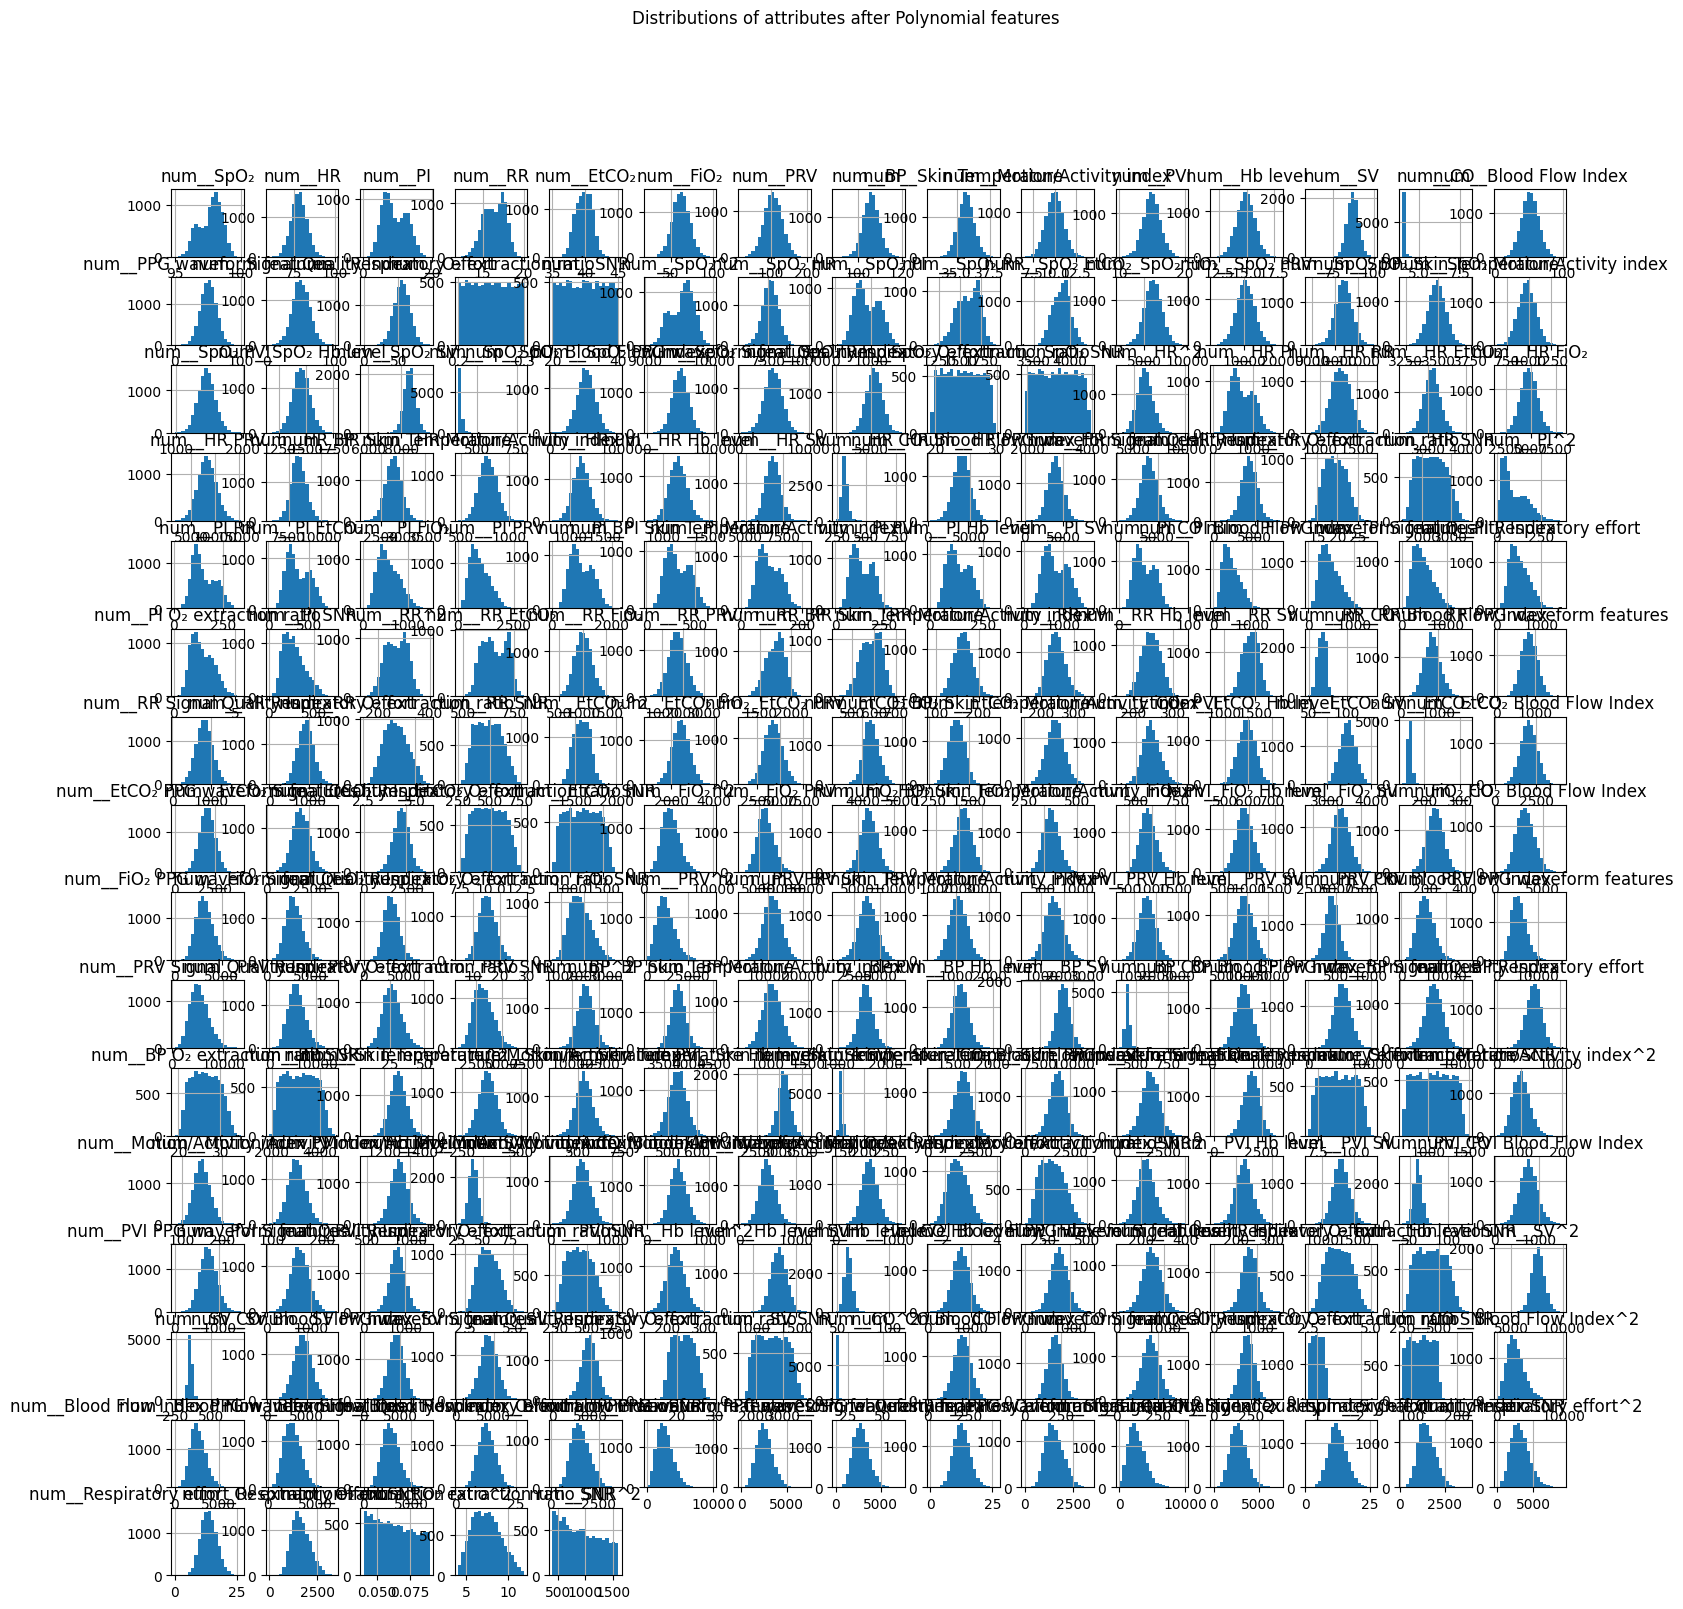

In [20]:
transformed_observation.hist(figsize=(18, 18), bins=20)
plt.suptitle("Distributions of attributes after Polynomial features")
plt.show()

scaler used ->StandardScaler

Makes training stable and fast

Recommended for almost all ML tasks.

---

transf used -> Transformer: PowerTransformer (Yeo-Johnson)

Converts skewed physiological measurements to more normal shapes

Reduces the dominance of extreme BP, HR, CO values

Handles zero and negative values with Yeo-Johnson

Improves linear model performance significantly


In [21]:
def get_numeric_columns(df):
    return df.select_dtypes(include=['int', 'float']).columns.tolist()

numeric_pipeline = Pipeline([
    ("power", PowerTransformer(method="yeo-johnson")),
    #("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scaler", StandardScaler()),
    #("scaler", MinMaxScaler(feature_range=(-1, 1)))
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

observation_pipeline = Pipeline([
    ("schema", EnforceSchema(schema=observation_schema)),
    ("ranges", EnforceValueRanges(ranges=valid_ranges)),
    ("drop_geo", FunctionTransformer(drop_columns, kw_args={'columns': ['latitude', 'longitude']}, validate=False)),
    ("drop_na", FunctionTransformer(drop_na, kw_args={'how': 'any'}, validate=False)), 
    ("encode", ColumnTransformer([
        ('cat', cat_pipeline, []),
        ('num', numeric_pipeline, get_numeric_columns)
    ], remainder='passthrough').set_output(transform="pandas")),
])

station_pipeline = Pipeline([
    ("schema", EnforceSchema(schema=station_schema)),
    ("drop_station_and_date", FunctionTransformer(drop_columns, kw_args={'columns': ['station', 'revision']}, validate=False)),
    ("parse_location", FunctionTransformer(parse_location, kw_args={'column': 'location'}, validate=False)),
    ("drop_na", FunctionTransformer(drop_na, kw_args={'how': 'any'}, validate=False)),
    ("encode", ColumnTransformer([
        ('cat', cat_pipeline, ['continent', 'city', 'code']),
        ('num', numeric_pipeline, get_numeric_columns)
    ], remainder='passthrough').set_output(transform="pandas")),
])


transformed_observation = observation_pipeline.fit_transform(X_train,y_train)
transformed_station = station_pipeline.fit_transform(pd.read_csv("dataset/station.csv", sep='\t'))

transformed_observation.head()

C:\Users\mbebe\AppData\Local\Temp\ipykernel_21180\1183780406.py:28: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  lambda x: dateparser.parse(str(x))


,num__SpO₂,num__HR,num__PI,num__RR,num__EtCO₂,num__FiO₂,num__PRV,num__BP,num__Skin Temperature,num__Motion/Activity index,num__PVI,num__Hb level,num__SV,num__CO,num__Blood Flow Index,num__PPG waveform features,num__Signal Quality Index,num__Respiratory effort,num__O₂ extraction ratio,num__SNR
108,2.241529,0.035210,1.186962,0.715950,0.376513,-0.229246,0.321797,1.904921,0.892083,1.385230,0.316855,-0.871952,0.524744,-0.346076,-0.755669,-0.466986,-0.704109,1.284423,-0.532905,1.001671
12092,-1.009404,0.268736,0.608312,-1.543483,-0.146314,1.056657,0.444607,0.584205,-0.306466,-0.968297,-1.203758,-0.296211,0.198872,-0.112570,0.819897,0.228158,-0.749841,0.980227,0.792622,-1.450753
9658,-1.890576,0.594747,0.309697,-2.918234,-0.021913,1.978583,-0.561582,-0.776612,-0.101027,2.687207,0.084497,0.374874,-0.405067,0.354443,-0.845873,-0.022195,1.871305,1.619050,0.399880,-1.073147
2929,-0.588099,-0.406534,-0.229970,-0.431378,0.266957,0.226903,-0.690361,-0.832310,-2.307414,-1.476076,-1.174869,1.729279,0.808427,-0.579582,-1.751408,-0.921782,0.399576,-0.567079,1.128137,0.918762
10405,0.597934,0.593434,0.428541,0.858602,1.840109,-0.106945,0.332869,-1.149125,-1.600628,-0.773598,1.253010,-2.126095,1.282045,0.237690,0.017320,0.401428,0.990062,0.069165,1.131478,1.276149


### D - Justification and Documentation

We transformed the observation dataset to make it compatible with model training by ensuring it contains only numerical values. We also demonstrated two different methods for data transformation and scaling, which help the model learn more effectively. For each method we described how the process works and what this hopes to achieve. In 3rd phase we can use these methods to make our models more accurate.

## 2.2 Feature Selection 

### A - Identification of Informative Features

Identify which attributes (features) in your data are informative with respect to the target variable (use at least 3 techniques and compare their results).

#### Variance Threshold

Removes features that have a low variance.

In [22]:
def get_numeric_columns(df):
    return df.select_dtypes(include=['int', 'float']).columns.tolist()

numeric_pipeline = Pipeline([
    ("power", PowerTransformer(method="yeo-johnson")),
    #("poly", PolynomialFeatures(degree=2, include_bias=False)),
    #("scaler", StandardScaler()),
    ("scaler", MinMaxScaler(feature_range=(-1, 1)))
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

observation_pipeline = Pipeline([
    ("schema", EnforceSchema(schema=observation_schema)),
    ("ranges", EnforceValueRanges(ranges=valid_ranges)),
    ("drop_geo", FunctionTransformer(drop_columns, kw_args={'columns': ['latitude', 'longitude']}, validate=False)),
    ("drop_na", FunctionTransformer(drop_na, kw_args={'how': 'any'}, validate=False)),
    ("encode", ColumnTransformer([
        ('cat', cat_pipeline, []),
        ('num', numeric_pipeline, get_numeric_columns)
    ], remainder='drop').set_output(transform="pandas")),
    ("variance_threshold", VarianceThreshold(threshold=0.01).set_output(transform="pandas")),
])

station_pipeline = Pipeline([
    ("schema", EnforceSchema(schema=station_schema)),
    ("drop_station_and_date", FunctionTransformer(drop_columns, kw_args={'columns': ['station', 'revision']}, validate=False)),
    ("parse_location", FunctionTransformer(parse_location, kw_args={'column': 'location'}, validate=False)),
    ("drop_na", FunctionTransformer(drop_na, kw_args={'how': 'any'}, validate=False)),
    ("encode", ColumnTransformer([
        ('cat', cat_pipeline, ['continent', 'city', 'code']),
        ('num', numeric_pipeline, get_numeric_columns)
    ], remainder='drop').set_output(transform="pandas")),
])




transformed_observation = observation_pipeline.fit_transform(X_train, y_train)
transformed_station = station_pipeline.fit_transform(pd.read_csv("dataset/station.csv", sep='\t'))

select_variance = observation_pipeline.named_steps['variance_threshold']
column_transformer = observation_pipeline.named_steps['encode']
feature_names = column_transformer.get_feature_names_out()
variances = select_variance.variances_
variance_df = pd.DataFrame({
    'feature': feature_names,
    'variance': variances,
    'selected': select_variance.get_support()
})

variance_df = variance_df.sort_values(by='variance', ascending=False)

print(variance_df)
transformed_observation.head()

C:\Users\mbebe\AppData\Local\Temp\ipykernel_21180\1183780406.py:28: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  lambda x: dateparser.parse(str(x))


                       feature      variance  selected
18    num__O₂ extraction ratio  3.338193e-01      True
19                    num__SNR  3.307393e-01      True
0                    num__SpO₂  1.150876e-01      True
3                      num__RR  1.079148e-01      True
2                      num__PI  9.912076e-02      True
11               num__Hb level  7.470150e-02      True
6                     num__PRV  7.402084e-02      True
9   num__Motion/Activity index  7.020677e-02      True
10                    num__PVI  7.016539e-02      True
16   num__Signal Quality Index  7.001718e-02      True
14       num__Blood Flow Index  6.705810e-02      True
5                    num__FiO₂  6.676783e-02      True
7                      num__BP  6.027917e-02      True
17     num__Respiratory effort  5.913989e-02      True
4                   num__EtCO₂  5.906535e-02      True
8        num__Skin Temperature  5.877173e-02      True
1                      num__HR  5.721598e-02      True
15  num__P

,num__SpO₂,num__HR,num__PI,num__RR,num__EtCO₂,num__FiO₂,num__PRV,num__BP,num__Skin Temperature,num__Motion/Activity index,num__PVI,num__Hb level,num__SV,num__Blood Flow Index,num__PPG waveform features,num__Signal Quality Index,num__Respiratory effort,num__O₂ extraction ratio,num__SNR
108,0.646961,-0.075644,0.597612,0.193844,0.017658,-0.024508,0.057487,0.537581,0.307535,0.287644,0.082924,-0.260123,0.410101,-0.204876,-0.092902,-0.203014,0.442998,-0.304962,0.600777
12092,-0.455904,-0.019785,0.415433,-0.548389,-0.109406,0.307762,0.090899,0.213321,0.016972,-0.335959,-0.319867,-0.102764,0.351103,0.203126,0.073040,-0.215115,0.369021,0.460889,-0.809611
9658,-0.754838,0.058197,0.321418,-1.000000,-0.079173,0.545983,-0.182852,-0.120784,0.066777,0.632624,0.021375,0.080655,0.241763,-0.228235,0.013277,0.478461,0.524375,0.233974,-0.592450
2929,-0.312979,-0.181308,0.151513,-0.183058,-0.008968,0.093358,-0.217889,-0.134459,-0.468115,-0.470503,-0.312215,0.450835,0.461460,-0.462728,-0.201469,0.089030,-0.007263,0.654740,0.553096
10405,0.089378,0.057883,0.358835,0.240705,0.373361,0.007094,0.060499,-0.212242,-0.296770,-0.284371,0.330900,-0.602900,0.547206,-0.004706,0.114403,0.245277,0.147463,0.656670,0.758629


#### Mutual Information

Measures the dependency between the variables, higher the output, higher the dependency.

In [23]:
def get_numeric_columns(df):
    return df.select_dtypes(include=['int', 'float']).columns.tolist()

numeric_pipeline = Pipeline([
    ("power", PowerTransformer(method="yeo-johnson")),
    #("poly", PolynomialFeatures(degree=2, include_bias=False)),
    #("scaler", StandardScaler()),
    ("scaler", MinMaxScaler(feature_range=(-1, 1)))
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

observation_pipeline = Pipeline([
    ("schema", EnforceSchema(schema=observation_schema)),
    ("ranges", EnforceValueRanges(ranges=valid_ranges)),
    ("drop_geo", FunctionTransformer(drop_columns, kw_args={'columns': ['latitude', 'longitude']}, validate=False)),
    ("drop_na", FunctionTransformer(drop_na, kw_args={'how': 'any'}, validate=False)),
    ("encode", ColumnTransformer([
        ('cat', cat_pipeline, []),
        ('num', numeric_pipeline, get_numeric_columns)
    ], remainder='drop').set_output(transform="pandas")),
    ("select_kbest", SelectKBest(score_func=f_regression, k=15).set_output(transform="pandas")) 

])

station_pipeline = Pipeline([
    ("schema", EnforceSchema(schema=station_schema)),
    ("drop_station_and_date", FunctionTransformer(drop_columns, kw_args={'columns': ['station', 'revision']}, validate=False)),
    ("parse_location", FunctionTransformer(parse_location, kw_args={'column': 'location'}, validate=False)),
    ("drop_na", FunctionTransformer(drop_na, kw_args={'how': 'any'}, validate=False)),
    ("encode", ColumnTransformer([
        ('cat', cat_pipeline, ['continent', 'city', 'code']),
        ('num', numeric_pipeline, get_numeric_columns)
    ], remainder='drop').set_output(transform="pandas")),
])


transformed_observation = observation_pipeline.fit_transform(X_train, y_train)
transformed_station = station_pipeline.fit_transform(pd.read_csv("dataset/station.csv", sep='\t'))

select_kbest_step = observation_pipeline.named_steps['select_kbest']
mask = select_kbest_step.get_support() 
column_transformer = observation_pipeline.named_steps['encode']
feature_names = column_transformer.get_feature_names_out()
scores = select_kbest_step.scores_
pvalues = select_kbest_step.pvalues_

kbest_df = pd.DataFrame({
    'feature': feature_names,
    'score': scores,
    'pvalue': pvalues,
    'selected': mask
}).sort_values('score', ascending=False)

print(kbest_df)
transformed_observation.head()

C:\Users\mbebe\AppData\Local\Temp\ipykernel_21180\1183780406.py:28: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  lambda x: dateparser.parse(str(x))


                       feature        score         pvalue  selected
3                      num__RR  7698.413247   0.000000e+00      True
0                    num__SpO₂  1551.982102  5.776425e-315      True
4                   num__EtCO₂   881.097023  2.144126e-185      True
2                      num__PI   141.977545   1.658833e-32      True
10                    num__PVI   128.573107   1.292298e-29      True
7                      num__BP     4.409002   3.577557e-02      True
1                      num__HR     2.264801   1.323758e-01      True
18    num__O₂ extraction ratio     1.767380   1.837380e-01      True
5                    num__FiO₂     1.606365   2.050340e-01      True
16   num__Signal Quality Index     1.355852   2.442864e-01      True
12                     num__SV     1.194406   2.744698e-01      True
14       num__Blood Flow Index     1.053877   3.046414e-01      True
9   num__Motion/Activity index     0.542119   4.615735e-01      True
15  num__PPG waveform features    

,num__SpO₂,num__HR,num__PI,num__RR,num__EtCO₂,num__FiO₂,num__PRV,num__BP,num__Motion/Activity index,num__PVI,num__SV,num__Blood Flow Index,num__PPG waveform features,num__Signal Quality Index,num__O₂ extraction ratio
108,0.646961,-0.075644,0.597612,0.193844,0.017658,-0.024508,0.057487,0.537581,0.287644,0.082924,0.410101,-0.204876,-0.092902,-0.203014,-0.304962
12092,-0.455904,-0.019785,0.415433,-0.548389,-0.109406,0.307762,0.090899,0.213321,-0.335959,-0.319867,0.351103,0.203126,0.073040,-0.215115,0.460889
9658,-0.754838,0.058197,0.321418,-1.000000,-0.079173,0.545983,-0.182852,-0.120784,0.632624,0.021375,0.241763,-0.228235,0.013277,0.478461,0.233974
2929,-0.312979,-0.181308,0.151513,-0.183058,-0.008968,0.093358,-0.217889,-0.134459,-0.470503,-0.312215,0.461460,-0.462728,-0.201469,0.089030,0.654740
10405,0.089378,0.057883,0.358835,0.240705,0.373361,0.007094,0.060499,-0.212242,-0.284371,0.330900,0.547206,-0.004706,0.114403,0.245277,0.656670


#### Recursive feature elimination

In [24]:
def get_numeric_columns(df):
    return df.select_dtypes(include=['int', 'float']).columns.tolist()

numeric_pipeline = Pipeline([
    ("power", PowerTransformer(method="yeo-johnson")),
    #("poly", PolynomialFeatures(degree=2, include_bias=False)),
    #("scaler", StandardScaler()),
    ("scaler", MinMaxScaler(feature_range=(-1, 1)))
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

observation_pipeline = Pipeline([
    ("schema", EnforceSchema(schema=observation_schema)),
    ("ranges", EnforceValueRanges(ranges=valid_ranges)),
    ("drop_geo", FunctionTransformer(drop_columns, kw_args={'columns': ['latitude', 'longitude']}, validate=False)),
    ("drop_na", FunctionTransformer(drop_na, kw_args={'how': 'any'}, validate=False)),
    ("variance_threshold", VarianceThreshold(threshold=0.01).set_output(transform="pandas")),
    ("encode", ColumnTransformer([
        ('cat', cat_pipeline, []),
        ('num', numeric_pipeline, get_numeric_columns)
    ], remainder='drop').set_output(transform="pandas")),
    ("RFE", RFE(SVR(kernel="linear"), n_features_to_select=5, step=1).set_output(transform="pandas")) 

])

station_pipeline = Pipeline([
    ("schema", EnforceSchema(schema=station_schema)),
    ("drop_station_and_date", FunctionTransformer(drop_columns, kw_args={'columns': ['station', 'revision']}, validate=False)),
    ("parse_location", FunctionTransformer(parse_location, kw_args={'column': 'location'}, validate=False)),
    ("drop_na", FunctionTransformer(drop_na, kw_args={'how': 'any'}, validate=False)),
    ("encode", ColumnTransformer([
        ('cat', cat_pipeline, ['continent', 'city', 'code']),
        ('num', numeric_pipeline, get_numeric_columns)
    ], remainder='drop').set_output(transform="pandas")),
])




transformed_observation = observation_pipeline.fit_transform(X_train, y_train)
transformed_station = station_pipeline.fit_transform(pd.read_csv("dataset/station.csv", sep='\t'))

select_rfe = observation_pipeline.named_steps['RFE']
mask = select_rfe.get_support() 
column_transformer = observation_pipeline.named_steps['encode']
feature_names = column_transformer.get_feature_names_out()
ranks = select_rfe.ranking_

rfe_df = pd.DataFrame({
    'feature': feature_names,
    'selected': mask,
    'rank': ranks
}).sort_values('rank', ascending=True)

print(rfe_df)

transformed_observation.head()

C:\Users\mbebe\AppData\Local\Temp\ipykernel_21180\1183780406.py:28: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  lambda x: dateparser.parse(str(x))


                       feature  selected  rank
0                    num__SpO₂      True     1
2                      num__PI      True     1
3                      num__RR      True     1
4                   num__EtCO₂      True     1
7                      num__BP      True     1
10                    num__PVI     False     2
16     num__Respiratory effort     False     3
12                     num__SV     False     4
11               num__Hb level     False     5
13       num__Blood Flow Index     False     6
5                    num__FiO₂     False     7
15   num__Signal Quality Index     False     8
14  num__PPG waveform features     False     9
8        num__Skin Temperature     False    10
1                      num__HR     False    11
6                     num__PRV     False    12
9   num__Motion/Activity index     False    13
17                    num__SNR     False    14


,num__SpO₂,num__PI,num__RR,num__EtCO₂,num__BP
108,0.646961,0.597612,0.193844,0.017658,0.537581
12092,-0.455904,0.415433,-0.548389,-0.109406,0.213321
9658,-0.754838,0.321418,-1.000000,-0.079173,-0.120784
2929,-0.312979,0.151513,-0.183058,-0.008968,-0.134459
10405,0.089378,0.358835,0.240705,0.373361,-0.212242


### B - Ranking of Features

Rank the identified features by importance.

### C - Justification and Documentation

Justify your choices/decisions for implementation (i.e., provide documentation).

## 2.3 Reproducibility of Preprocessing

### Code Generalization for Reuse and Pipeline Implementation

Modify your preprocessing code for the training dataset so that it can be reused without further modifications to preprocess the test dataset in a machine learning context. Use the sklearn.pipeline functionality.